# Goal: Output a graphic that compares the top scorers (or any set of scorers) based on situational breakdowns
- will use pie charts scaled to the size of total goals, assists, points, ect 

## Setup - Dependencies - Ect

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from PIL import Image

from config import recent_clean_db, last_game_date, tourney_bubble
import sqlite3


# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')


# ################################################################################
# roster_file = os.path.join(data_folder, 'roster_2024_current_v2.csv') # PATH TO THE ROSTER FILE
# roster_df = pd.read_csv(roster_file) # read as dataframe

# # Path to school info table (csv)
# school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
# school_info_df = pd.read_csv(school_info_file)

# print(roster_df.columns)

### Database Connection

In [2]:
######
##### DB PATH IMPORT
## Get DB path and last game date from global settings
from config import recent_clean_db, last_game_date, tourney_bubble

## Set Standard Figure Size (right now just used for scatter plot)
top_fig_size = (9, 12) # Top Figure Size

db_path = recent_clean_db # Database Path


conn = sqlite3.connect(db_path) # Connect to the database
# verify the connection
cursor = conn.cursor() 
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# extract scoring table from database
scoring_query = "SELECT * FROM scoring_summary"
scoring_df = pd.read_sql_query(scoring_query, conn)

# Clean Up Team names
# Drop any non-letter characters from the Team, Away_Team, and Home_Team columns
scoring_df['Team'] = scoring_df['Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace(r'[^a-zA-Z]', '')

# scoring_df.head()

In [3]:
## Hotfix for problems with punctuation in team names

# Replace punctuation in team names (columns Team, Home_Team, Away_Team)
scoring_df['Team'] = scoring_df['Team'].str.replace('.', '')
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace('.', '')
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace('.', '')

scoring_df['Team'] = scoring_df['Team'].str.replace("'", '')
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace("'", '')
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace("'", '')




In [4]:

# Clean and preprocess the data
scoring_df['PP'] = scoring_df['PP'].fillna('')  # Replace NaN with empty string
scoring_df['Assist1'] = scoring_df['Assist1'].fillna('')
scoring_df['Assist2'] = scoring_df['Assist2'].fillna('')

# Define period mapping
period_mapping = {
    '1st Period': '1st_goals',
    '2nd Period': '2nd_goals',
    '3rd Period': '3rd_goals',
    'Overtime': 'ot_goals'
}

# Define game situation mappings
game_situation_mapping = {
    'PP': 'powerplay_goals',
    'SH': 'shorthanded_goals',
    '3x5': 'shorthanded_goals',
    '4x4': '4on4_goals',
    '3x3': '3on3_goals',
    '5x3': 'powerplay_goals',
    'EA': 'extra_attacker_goals',
    'EN': 'empty_net_goals',
    'PS': 'penalty_shots_goals'
}

# Initialize goal tally dictionary
goal_tally = {}

# Process each row to tally goals
for _, row in scoring_df.iterrows():
    player = row['Player']
    team = row['Team']
    
    # Unique key for each player-team combination
    key = (player, team)
    
    # Initialize if player not seen before
    if key not in goal_tally:
        goal_tally[key] = {
            'Total_Goals': 0, '1st_goals': 0, '2nd_goals': 0, '3rd_goals': 0, 'ot_goals': 0,
            'home_goals': 0, 'away_goals': 0, '5on5_goals': 0, '4on4_goals': 0, '3on3_goals': 0,
            'powerplay_goals': 0, 'shorthanded_goals': 0, 'empty_net_goals': 0, 
            'extra_attacker_goals': 0, 'penalty_shots_goals': 0, 'unassisted_goals': 0,
            'one_assist_goals': 0, 'two_assist_goals': 0
        }
    
    # Increment total goals
    goal_tally[key]['Total_Goals'] += 1
    
    # Tally by period
    if row['Period'] in period_mapping:
        goal_tally[key][period_mapping[row['Period']]] += 1

    
    # Tally by location - Very Basic home/away
    if row['Home_Team'] == team:
        goal_tally[key]['home_goals'] += 1
    else:
        goal_tally[key]['away_goals'] += 1
    ### Could be improved to nuetral site games by looking up game details by game id
    
    # Tally by game situation
    game_situations = row['PP'].split(',')
    if row['PP'] == '':
        goal_tally[key]['5on5_goals'] += 1  # Default 5-on-5 goal
    else:
        for situation in game_situations:
            situation = situation.strip()
            if situation in game_situation_mapping:
                goal_tally[key][game_situation_mapping[situation]] += 1

    # Tally by assist count
    if row['Assist1'] == '' and row['Assist2'] == '':
        goal_tally[key]['unassisted_goals'] += 1
    elif row['Assist1'] != '' and row['Assist2'] == '':
        goal_tally[key]['one_assist_goals'] += 1
    else:
        goal_tally[key]['two_assist_goals'] += 1

# Convert goal tally dictionary to DataFrame
goal_tally_df = pd.DataFrame.from_dict(goal_tally, orient='index').reset_index()
goal_tally_df.columns = ['Player', 'Team'] + list(goal_tally_df.columns[2:])


# Convert tally counts to percentages of total goals
goal_tally_by_pct_df = goal_tally_df.copy()

# Exclude non-numeric columns
numeric_cols = goal_tally_by_pct_df.columns[2:]

# Convert each column (except 'Total_Goals') to a percentage of total goals
goal_tally_by_pct_df.loc[:, numeric_cols.difference(['Total_Goals'])] = (
    goal_tally_by_pct_df[numeric_cols.difference(['Total_Goals'])]
    .div(goal_tally_by_pct_df["Total_Goals"], axis=0) * 100
).round(2)




# Display the processed DataFrame
print(goal_tally_df.head())

             Player             Team  Total_Goals  1st_goals  2nd_goals  \
0      Isaac Howard   Michigan State           24          3          6   
1    Connor Milburn    Lake Superior            9          4          2   
2    Daniel Russell   Michigan State           12          1          6   
3  William Whitelaw         Michigan           11          3          4   
4    Brian Carrabes  Minnesota State           10          2          4   

   3rd_goals  ot_goals  home_goals  away_goals  5on5_goals  4on4_goals  \
0         14         1           7          17          16           1   
1          3         0           5           4           4           0   
2          3         2           6           6           4           1   
3          4         0           5           6           7           0   
4          4         0           5           5           8           0   

   3on3_goals  powerplay_goals  shorthanded_goals  empty_net_goals  \
0           1                4    

C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\3004675439.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12.5   44.44   8.33 ...   0.   100.     0.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  goal_tally_by_pct_df.loc[:, numeric_cols.difference(['Total_Goals'])] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\3004675439.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 25.    22.22  50.   ... 100.     0.   100.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  goal_tally_by_pct_df.loc[:, numeric_cols.difference(['Total_Goals'])] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\3004675439.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.17  0.   16.67

In [5]:
# Convert time to a sortable format (MM:SS to total seconds)
def time_to_seconds(time_str):
    """Convert MM:SS time format to total seconds."""
    if isinstance(time_str, str):
        minutes, seconds = map(int, time_str.split(":"))
        return minutes * 60 + seconds
    return 0

# Add a sortable time column
scoring_df["Time_Seconds"] = scoring_df["Time"].apply(time_to_seconds)

# Sort data by game, period, and time
period_order = {"1st Period": 1, "2nd Period": 2, "3rd Period": 3, "Overtime": 4}
scoring_df["Period_Order"] = scoring_df["Period"].map(period_order)

scoring_df = scoring_df.sort_values(by=["Game_ID", "Period_Order", "Time_Seconds"]).reset_index(drop=True)

# Initialize tracking variables
game_scores = {}  # {Game_ID: {Team_A: score, Team_B: score}}
score_records = []

# Process each game sequentially
for _, row in scoring_df.iterrows():
    game_id = row["Game_ID"]
    team_scoring = row["Team"]
    home_team = row["Home_Team"]
    away_team = row["Away_Team"]

    # Initialize game score if first goal in game
    if game_id not in game_scores:
        game_scores[game_id] = {home_team: 0, away_team: 0}

    # Get the score before the goal
    score_before = game_scores[game_id].copy()

    # Update score for the scoring team
    game_scores[game_id][team_scoring] += 1

    # Determine score difference before goal
    team_score_before = score_before[team_scoring]
    opponent_team = home_team if team_scoring == away_team else away_team
    opponent_score_before = score_before[opponent_team]

    score_diff = team_score_before - opponent_score_before

    # Classify goal situation
    if score_diff >= 2:
        situation = "Leading by 2+"
    elif score_diff == 1:
        situation = "Leading by 1"
    elif score_diff == 0:
        situation = "Tied"
    elif score_diff == -1:
        situation = "Trailing by 1"
    else:
        situation = "Trailing by 2+"

    # Store result
    score_records.append({
        "Game_ID": game_id,
        "Team": team_scoring,
        "Player": row["Player"],
        "Period": row["Period"],
        "Time": row["Time"],
        "Score_Before": f"{team_score_before}-{opponent_score_before}",
        "Game_Situation": situation
    })

# Convert to DataFrame
score_summary_df = pd.DataFrame(score_records)

# Display the processed DataFrame
print(score_summary_df.head())

                              Game_ID           Team             Player  \
0  2024-10-04-Arizona State-Air Force  Arizona State    Bennett Schimek   
1  2024-10-04-Arizona State-Air Force  Arizona State      Dylan Jackson   
2  2024-10-04-Arizona State-Air Force  Arizona State    Bennett Schimek   
3  2024-10-04-Arizona State-Air Force      Air Force  Clayton Cosentino   
4  2024-10-04-Arizona State-Air Force  Arizona State        Kyle Smolen   

       Period   Time Score_Before  Game_Situation  
0  1st Period  12:30          0-0            Tied  
1  1st Period  15:57          1-0    Leading by 1  
2  2nd Period   5:26          2-0   Leading by 2+  
3  2nd Period   8:16          0-3  Trailing by 2+  
4  2nd Period  15:20          3-1   Leading by 2+  


In [6]:
# Group by Player and Team, then tally goals by game situation
goal_situation_tally = score_summary_df.groupby(["Player", "Team", "Game_Situation"]).size().unstack(fill_value=0).reset_index()

# Rename columns for clarity
goal_situation_tally.columns = [
    "Player", "Team", "Goals_Leading_by_2+", "Goals_Leading_by_1",
    "Goals_Tied", "Goals_Trailing_by_1", "Goals_Trailing_by_2+"
]

# Add a total goals column for reference
goal_situation_tally["Total_Goals"] = goal_situation_tally.iloc[:, 2:].sum(axis=1)

# Display the processed DataFrame
goal_situation_tally.head()


,Player,Team,Goals_Leading_by_2+,Goals_Leading_by_1,Goals_Tied,Goals_Trailing_by_1,Goals_Trailing_by_2+,Total_Goals
0,A.J. Hodges,Bentley,1,1,3,2,1,8
1,Aaron Bohlinger,Quinnipiac,1,0,1,1,0,3
2,Aaron Huglen,Minnesota,0,4,1,0,0,5
3,Aaron Pionk,Minnesota Duluth,0,0,3,0,0,3
4,Aaron Schwartz,Quinnipiac,2,6,1,2,1,12


In [7]:
# Merge the goal situation tally with the goal tally DataFrame
goal_tally_df = goal_tally_df.merge(goal_situation_tally, on=["Player", "Team"], how="left")
goal_tally_df.fillna(0, inplace=True)

### Handling Assist Tally

In [8]:
# Recalculate the total assists directly from the raw scoring summary

# Initialize a list to store assist records
assist_records = []

# Process each goal event for assists
for _, row in score_summary_df.iterrows():
    game_id = row["Game_ID"]
    period = row["Period"]
    time = row["Time"]
    game_situation = row["Game_Situation"]
    team = row["Team"]
    
    # Get assists from original scoring data
    original_row = scoring_df[
        (scoring_df["Game_ID"] == game_id) & 
        (scoring_df["Team"] == team) & 
        (scoring_df["Period"] == period) & 
        (scoring_df["Time"] == time)
    ].iloc[0]

    assist1 = original_row["Assist1"] if pd.notna(original_row["Assist1"]) else None
    assist2 = original_row["Assist2"] if pd.notna(original_row["Assist2"]) else None

    # Record first assist if exists
    if assist1:
        assist_records.append({
            "Player": assist1,
            "Team": team,
            "Assist_Type": "First_Assist",
            "Game_Situation": game_situation,
            "Period": period
        })

    # Record second assist if exists
    if assist2:
        assist_records.append({
            "Player": assist2,
            "Team": team,
            "Assist_Type": "Second_Assist",
            "Game_Situation": game_situation,
            "Period": period
        })

# Convert to DataFrame
assist_df = pd.DataFrame(assist_records)

# Directly count total assists from the raw data
total_assists_df = assist_df.groupby(["Player", "Team"]).size().reset_index(name="Total_Assists")

# Tally assists by game situation
assist_by_situation = assist_df.groupby(["Player", "Team", "Game_Situation"]).size().unstack(fill_value=0).reset_index()
assist_by_situation.columns = ["Player", "Team"] + [f"Assists_{col}" for col in assist_by_situation.columns[2:]]

# Tally assists by period
assist_by_period = assist_df.groupby(["Player", "Team", "Period"]).size().unstack(fill_value=0).reset_index()
assist_by_period.columns = ["Player", "Team"] + [f"Assists_{col}" for col in assist_by_period.columns[2:]]

# Tally assists by type (first vs. second assist)
assist_by_type = assist_df.groupby(["Player", "Team", "Assist_Type"]).size().unstack(fill_value=0).reset_index()
assist_by_type.columns = ["Player", "Team", "First_Assists", "Second_Assists"]

# Merge all assist tallies into a single DataFrame
assist_tally_df = total_assists_df.merge(assist_by_situation, on=["Player", "Team"], how="outer")
assist_tally_df = assist_tally_df.merge(assist_by_period, on=["Player", "Team"], how="outer")
assist_tally_df = assist_tally_df.merge(assist_by_type, on=["Player", "Team"], how="outer")

# Fill NaN values with 0 (for players who didn't have assists in certain situations)
assist_tally_df = assist_tally_df.fillna(0)

# Display the processed DataFrame
print(assist_tally_df.head())


            Player              Team  Total_Assists  Assists_Leading by 1  \
0      A.J. Hodges           Bentley              9                     3   
1    A.J. Macaulay     Bemidji State              2                     0   
2  Aaron Bohlinger        Quinnipiac             11                     2   
3     Aaron Huglen         Minnesota             14                     4   
4      Aaron Pionk  Minnesota Duluth             23                     3   

   Assists_Leading by 2+  Assists_Tied  Assists_Trailing by 1  \
0                      1             1                      3   
1                      0             0                      2   
2                      3             5                      1   
3                      2             4                      3   
4                      2             8                      4   

   Assists_Trailing by 2+  Assists_1st Period  Assists_2nd Period  \
0                       1                   0                   5   
1       

In [9]:
### Merge all the dataframes together

# Merge goal tally and assist tally DataFrames
player_stats_df = goal_tally_df.merge(assist_tally_df, on=["Player", "Team"], how="outer")

# Create a Column with Total Points - This is the sum of goals and assists
player_stats_df["Total_Points"] = player_stats_df["Total_Goals_x"] + player_stats_df["Total_Assists"]

# Fill NaN values with 0 (for players who didn't have goals or assists)
player_stats_df = player_stats_df.fillna(0)

# Convert all columns except Player and Team to integer type
numeric_cols = player_stats_df.columns[2:]
player_stats_df[numeric_cols] = player_stats_df[numeric_cols].astype(int)

# Display the merged DataFrame
print(player_stats_df.head())

            Player              Team  Total_Goals_x  1st_goals  2nd_goals  \
0      A.J. Hodges           Bentley              8          2          1   
1    A.J. Macaulay     Bemidji State              0          0          0   
2  Aaron Bohlinger        Quinnipiac              3          2          0   
3     Aaron Huglen         Minnesota              5          1          3   
4      Aaron Pionk  Minnesota Duluth              3          1          1   

   3rd_goals  ot_goals  home_goals  away_goals  5on5_goals  ...  Assists_Tied  \
0          4         1           3           5           3  ...             1   
1          0         0           0           0           0  ...             0   
2          1         0           0           3           0  ...             5   
3          1         0           2           3           4  ...             4   
4          0         1           3           0           1  ...             8   

   Assists_Trailing by 1  Assists_Trailing by 2+  

In [10]:
player_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Player                  1473 non-null   object
 1   Team                    1473 non-null   object
 2   Total_Goals_x           1473 non-null   int32 
 3   1st_goals               1473 non-null   int32 
 4   2nd_goals               1473 non-null   int32 
 5   3rd_goals               1473 non-null   int32 
 6   ot_goals                1473 non-null   int32 
 7   home_goals              1473 non-null   int32 
 8   away_goals              1473 non-null   int32 
 9   5on5_goals              1473 non-null   int32 
 10  4on4_goals              1473 non-null   int32 
 11  3on3_goals              1473 non-null   int32 
 12  powerplay_goals         1473 non-null   int32 
 13  shorthanded_goals       1473 non-null   int32 
 14  empty_net_goals         1473 non-null   int32 
 15  extr

In [11]:
## Save as CSV in TEMP folder
player_stats_df.to_csv(os.path.join(temp_folder, 'player_goal_assist_breakdown.csv'), index=False)

PermissionError: [Errno 13] Permission denied: 'c:\\Users\\jbanc\\OneDrive\\Desktop\\Project\\college_hockey_2425\\workbook\\..\\TEMP\\player_goal_assist_breakdown.csv'

## Begin Plotting Code

C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\728184282.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = row[cols].fillna(0).values.astype(float)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\728184282.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = row[cols].fillna(0).values.astype(float)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_22372\728184282.py:121: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) i

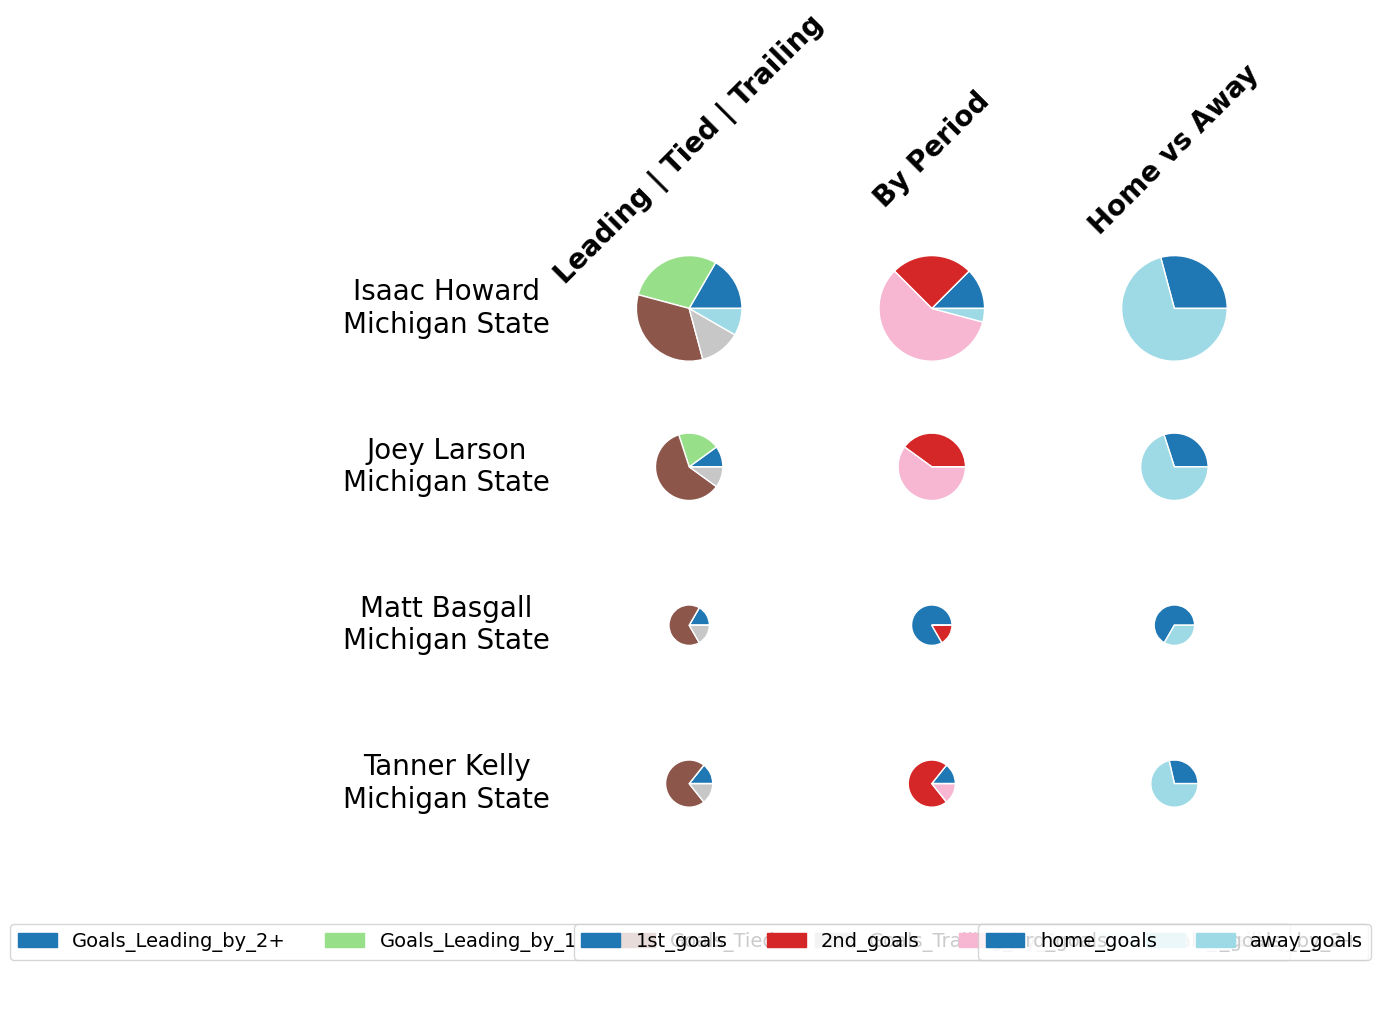

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ========================
# Define the breakdown groups
# ========================

# For GOALS there are 5 groups:
GOALS_GROUPS = {
    "Leading | Tied | Trailing": ["Goals_Leading_by_2+", "Goals_Leading_by_1", "Goals_Tied", "Goals_Trailing_by_1", "Goals_Trailing_by_2+"],
    "By Period": ["1st_goals", "2nd_goals", "3rd_goals", "ot_goals"],
    "Home vs Away": ["home_goals", "away_goals"],
    "Game Situation": ["5on5_goals", "4on4_goals", "3on3_goals", "powerplay_goals", "shorthanded_goals", "empty_net_goals", "extra_attacker_goals", "penalty_shots_goals"],
    "Assisted": ["unassisted_goals", "one_assist_goals", "two_assist_goals"]
}

# For ASSISTS there are 3 groups:
ASSISTS_GROUPS = {
    "Leading | Trailing Assists": ["Assists_Leading by 1", "Assists_Leading by 2+", "Assists_Tied", "Assists_Trailing by 1", "Assists_Trailing by 2+"],
    "Assist By Period": ["Assists_1st Period", "Assists_2nd Period", "Assists_3rd Period", "Assists_Overtime"],
    "First | Second Assist": ["First_Assists", "Second_Assists"]
}

# Combine groups if needed.
GROUP_DICT = {}
GROUP_DICT.update(GOALS_GROUPS)
GROUP_DICT.update(ASSISTS_GROUPS)

# ========================
# Helper Function: Plot a Pie Chart in a given Axes
# ========================
def plot_pie_chart(ax, values, colors, radius):
    """
    Plots a pie chart on the given axes using the provided values, colors, and radius.
    If the total is 0, a '0' is displayed instead.
    """
    total = np.sum(values)
    if total == 0:
        ax.text(0.5, 0.5, "0", horizontalalignment='center', verticalalignment='center', fontsize=12)
        return
    # Draw pie chart; the wedges are outlined in white.
    wedges, _ = ax.pie(values, colors=colors, radius=radius, wedgeprops=dict(edgecolor='white'))
    return wedges

# ========================
# Main Plotting Function
# ========================
def plot_player_breakdowns(data, player_list, groups_to_plot, max_radius=1.0):
    """
    Creates a multi-panel figure comparing selected players' stat breakdowns.
    
    Parameters:
      data           : DataFrame with player stats. Assumes a 'Player' and 'Team' column.
      player_list    : List of player names (as in the 'Player' column) to include.
      groups_to_plot : List of group keys (keys in GROUP_DICT) to plot as columns.
      max_radius     : Maximum radius for the pie chart corresponding to the highest total.
    """
    # Filter the dataset for the selected players.
    df = data[data['Player'].isin(player_list)].copy()
    
    if df.empty:
        print("No matching players found in the dataset.")
        return
    
    num_players = df.shape[0]
    num_groups = len(groups_to_plot)
    
    # Create a grid:
    # Rows: 1 for column titles + one per player + 1 for legends.
    # Columns: 1 for player info + one per stat breakdown group.
    nrows = num_players + 2
    ncols = num_groups + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 2 * nrows))
    
    # Ensure axes is a 2D array
    if nrows == 1:
        axes = np.array([axes])
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    # -------------------
    # Top Row: Titles for each group column.
    # -------------------
    axes[0, 0].axis('off')  # leftmost cell (could display "Player Info" if desired)
    for j, group in enumerate(groups_to_plot):
        axes[0, j+1].axis('off')
        axes[0, j+1].text(0.5, 0.5, group, 
                            rotation=45,
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            fontsize=20, 
                            fontweight='bold')
    
    # -------------------
    # Pre-calculate maximum totals per group (for scaling the pie charts)
    # -------------------
    max_totals = {}
    for group in groups_to_plot:
        cols = GROUP_DICT[group]
        totals = df[cols].fillna(0).sum(axis=1)
        max_totals[group] = totals.max() if totals.max() > 0 else 1
    
    # -------------------
    # Middle Rows: One row per player.
    # -------------------
    for i, (_, row) in enumerate(df.iterrows()):
        # Left column: Player info.
        ax_info = axes[i+1, 0]
        ax_info.axis('off')
        info_text = f"{row['Player']}\n{row['Team']}"
        ax_info.text(0.5, 0.5, info_text, horizontalalignment='center', verticalalignment='center', fontsize=20)
        
        # Plot each breakdown group as a pie chart.
        for j, group in enumerate(groups_to_plot):
            ax = axes[i+1, j+1]
            ax.axis('equal')  # Ensure pie chart appears circular.
            ax.axis('off')
            cols = GROUP_DICT[group]
            values = row[cols].fillna(0).values.astype(float)
            total = values.sum()
            # Compute radius (use a minimum value if total is 0).
            radius = max_radius * (total / max_totals[group]) if total > 0 else 0.1
            # Define colors – here we use a colormap that can generate as many colors as needed.
            cmap = plt.get_cmap('tab20')
            colors = [cmap(i) for i in np.linspace(0, 1, len(cols))]
            plot_pie_chart(ax, values, colors, radius)
    
    # -------------------
    # Bottom Row: Legends for each group column.
    # -------------------
    axes[-1, 0].axis('off')  # Leftmost cell left blank.
    for j, group in enumerate(groups_to_plot):
        ax_legend = axes[-1, j+1]
        ax_legend.axis('off')
        cols = GROUP_DICT[group]
        cmap = plt.get_cmap('tab20')
        colors = [cmap(i) for i in np.linspace(0, 1, len(cols))]
        patches = [mpatches.Patch(color=colors[k], label=cols[k]) for k in range(len(cols))]
        # Create a legend in this cell.
        ax_legend.legend(handles=patches, loc='center', ncol=len(cols), fontsize=14)
    
    plt.tight_layout()
    plt.show()

# ========================
# Example Usage
# ========================
if __name__ == "__main__":
    # Load your dataset.
    data = player_stats_df
    
    # Define the list of players to compare.
    # (Adjust the names to match those in your CSV, e.g., "John Doe")
    players_to_plot = ["Isaac Howard", "Joey Larson", "Tanner Kelly", "Matt Basgall"]
    
    # Select which groups to include. For example, to compare goal breakdowns:
    groups_to_include = ["Leading | Tied | Trailing", "By Period", "Home vs Away"]
    # You can also include assist groups if you wish:
    # groups_to_include += ["Game State Assists", "Assist Timing", "Assist Order"]
    
    # Generate the plot.
    plot_player_breakdowns(data, players_to_plot, groups_to_include)
